# Analyzing bike usage by time of day and day of week

For anyone managing a bike share system, understanding the patterns of bike use is pretty important. Capacity planning, in terms of the number of bikes needed, can be aided by analysis of the number of bikes in use by time of day and day of week. In this notebook, I show how the package [hillmaker](https://github.com/misken/hillmaker) can be used to create statistical plots of bike use. Hillmaker was originally developed for use in healthcare capacity planning problems but can be used for any service system in which start times and stop times are available. This cycle share dataset is ideal.

In this first example we'll compare bike use patterns by members vs. short-term pass holders. Our goal is to compute the mean and percentiles of the number of bikes in use by hour of day and day of week. 

### Module imports
To run Hillmaker we only need to import a few modules. Since the main Hillmaker function uses Pandas DataFrames for both data input and output, we need to import `pandas` in addition to `hillmaker`.

In [2]:
import pandas as pd
import hillmaker as hm

We'll use matplotlib for the plotting. There's some trickiness involved in x-axis formatting that can be solved with a `DateFormatter`.

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

In [4]:
%matplotlib inline

### Read trip data file

Read the trip data from a csv file into a DataFrame and tell Pandas which fields to treat as dates.

In [6]:
file_trip_data = './data/trip.csv'

In [8]:
trip_df_raw = pd.read_csv(file_trip_data, parse_dates=['starttime','stoptime'], on_bad_lines='skip')
trip_df_raw.info() # Check out the structure of the resulting DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236065 entries, 0 to 236064
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   trip_id            236065 non-null  int64         
 1   starttime          236065 non-null  datetime64[ns]
 2   stoptime           236065 non-null  datetime64[ns]
 3   bikeid             236065 non-null  object        
 4   tripduration       236065 non-null  float64       
 5   from_station_name  236065 non-null  object        
 6   to_station_name    236065 non-null  object        
 7   from_station_id    236065 non-null  object        
 8   to_station_id      236065 non-null  object        
 9   usertype           236065 non-null  object        
 10  gender             146171 non-null  object        
 11  birthyear          146167 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(7)
memory usage: 21.6+ MB


There are some duplicate rows in this dataset. Let's get rid of them.

In [9]:
trip_df = trip_df_raw.drop_duplicates()

In [10]:
trip_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236065 entries, 0 to 236064
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   trip_id            236065 non-null  int64         
 1   starttime          236065 non-null  datetime64[ns]
 2   stoptime           236065 non-null  datetime64[ns]
 3   bikeid             236065 non-null  object        
 4   tripduration       236065 non-null  float64       
 5   from_station_name  236065 non-null  object        
 6   to_station_name    236065 non-null  object        
 7   from_station_id    236065 non-null  object        
 8   to_station_id      236065 non-null  object        
 9   usertype           236065 non-null  object        
 10  gender             146171 non-null  object        
 11  birthyear          146167 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(7)
memory usage: 23.4+ MB


In [11]:
trip_df.head(3)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
0,431,2014-10-13 10:31:00,2014-10-13 10:48:00,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1960.0
1,432,2014-10-13 10:32:00,2014-10-13 10:48:00,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1970.0
2,433,2014-10-13 10:33:00,2014-10-13 10:48:00,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1988.0


In [12]:
trip_df.tail(5)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
236060,255241,2016-08-31 23:34:00,2016-08-31 23:45:00,SEA00201,679.532,Harvard Ave & E Pine St,2nd Ave & Spring St,CH-09,CBD-06,Short-Term Pass Holder,NaN,NaN
236061,255242,2016-08-31 23:48:00,2016-09-01 00:20:00,SEA00247,1965.418,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN
236062,255243,2016-08-31 23:47:00,2016-09-01 00:20:00,SEA00300,1951.173,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN
236063,255244,2016-08-31 23:49:00,2016-09-01 00:20:00,SEA00047,1883.299,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN
236064,255245,2016-08-31 23:49:00,2016-09-01 00:20:00,SEA00442,1896.031,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN


### Overall ride counts by user type
Let's create a simple function to summarize factor variables such as `usertype`.

In [13]:
def factorsummary(series):
    print(series.name)
    x_null = series.isnull().sum()
    x_notnull = series.count()
    x_tot = x_notnull + x_null
    print("total\t{}".format(x_tot))
    print("nonnull\t{}".format(x_notnull))
    print("null\t{}\n".format(x_null))
    print(series.value_counts())
    

In [14]:
factorsummary(trip_df['usertype'])

usertype
total	236065
nonnull	236065
null	0

Member                    146171
Short-Term Pass Holder     89894
Name: usertype, dtype: int64


### Creating occupancy summaries
The primary function in `hillmaker` is called `make_hills`. Let's get a little help on this function.

In [15]:
help(hm.make_hills)

Help on function make_hills in module hillmaker.hills:

make_hills(scenario_name, stops_df, in_field, out_field, start_analysis_dt, end_analysis_dt, cat_field=None, bin_size_minutes=60, percentiles=(0.25, 0.5, 0.75, 0.95, 0.99), cats_to_exclude=None, occ_weight_field=None, totals=1, cap=None, nonstationary_stats=True, stationary_stats=True, no_censored_departures=False, export_bydatetime_csv=True, export_summaries_csv=True, export_dow_png=False, export_week_png=False, xlabel=None, ylabel=None, output_path=WindowsPath('.'), edge_bins=1, verbosity=0)
    Compute occupancy, arrival, and departure statistics by category, time bin of day and day of week.
    
    Main function that first calls `bydatetime.make_bydatetime` to calculate occupancy, arrival
    and departure values by date by time bin and then calls `summarize.summarize`
    to compute the summary statistics.
    
    Parameters
    ----------
    
    scenario_name : str
        Used in output filenames
    stops_df : DataFram

You can read more about Hillmaker at [https://github.com/misken/hillmaker](https://github.com/misken/hillmaker). It's free and open source.

#### Specify values for all the required inputs:


In [16]:
# Required inputs
# ---------------

# scenario name
scenario = 'bikeshare_1'

# Column name in trip_df corresponding to the bike rental time
in_fld_name = 'starttime'

# Column name in trip_df corresponding to the bike return time
out_fld_name = 'stoptime'

# Column name in trip_df corresponding to some categorical field for grouping
cat_fld_name = 'usertype'

# Start and end times for the analysis. We'll just use data from 2015.
start = '1/1/2015'
end = '12/31/2015 23:45'

# Optional inputs
# ---------------

# Verbosity level of hillmaker messages
verbose = 1

# Path to destination location for csv output files produced by hillmaker
output = './output'


Now we'll call the main `make_hills` function. This used to take about 5 minutes. Last year I totally overhauled the computational guts of **hillmaker** and sped it up dramatically. The key was to do almost all occupancy computations in **numpy** arrays instead of **pandas** dataframes. Now this takes just over 10 seconds.

In [18]:
hills_1 = hm.make_hills(scenario, trip_df, in_fld_name, out_fld_name, start, end, cat_fld_name, 
              output_path = output, verbosity=verbose)

2023-04-26 15:09:57,900 - hillmaker.bydatetime - INFO - min of intime: 2014-12-31 22:59:00
2023-04-26 15:09:57,901 - hillmaker.bydatetime - INFO - max of intime: 2015-12-31 23:17:00
2023-04-26 15:09:57,902 - hillmaker.bydatetime - INFO - min of outtime: 2015-01-01 00:23:00
2023-04-26 15:09:57,903 - hillmaker.bydatetime - INFO - max of outtime: 2016-01-01 02:02:00
2023-04-26 15:09:57,904 - hillmaker.bydatetime - INFO - start analysis: 2015-01-01, end analysis: 2015-12-31
2023-04-26 15:09:58,010 - hillmaker.bydatetime - INFO - min of entry time_bin = -2
2023-04-26 15:09:58,014 - hillmaker.bydatetime - INFO - max of exit time_bin = 8762 and num_bins=8760
2023-04-26 15:09:59,690 - hillmaker.bydatetime - INFO - cat Short-Term Pass Holder {'left': 4, 'inner': 52043, 'right': 1}
2023-04-26 15:09:59,789 - hillmaker.bydatetime - INFO - cat Short-Term Pass Holder num_arrivals_hm 52044 num_arrivals_stops 52044
2023-04-26 15:09:59,792 - hillmaker.bydatetime - INFO - cat Short-Term Pass Holder num_

In [19]:
hills_1.keys()

dict_keys(['bydatetime', 'summaries'])

We are primarily interested in the occupancy (i.e. number of bikes in use) DataFrame contained in the `hills_1` dictionary returned by `make_hills`. You can also go to the specified output folder to see a csv export of all of the returned DataFrames.

In [22]:
hills_1['summaries'].keys()

dict_keys(['nonstationary', 'stationary'])

In [24]:
hills_1['summaries']['nonstationary'].keys()

dict_keys(['usertype_dow_binofday', 'dow_binofday'])

In [37]:
occ_user_type_df = hills_1['summaries']['nonstationary']['usertype_dow_binofday']['occupancy']
occ_user_type_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 336 entries, ('Member', 0, 'Mon', 0, '00:00') to ('Short-Term Pass Holder', 6, 'Sun', 23, '23:00')
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   count   336 non-null    float64
 1   mean    336 non-null    float64
 2   min     336 non-null    float64
 3   max     336 non-null    float64
 4   stdev   336 non-null    float64
 5   sem     336 non-null    float64
 6   var     336 non-null    float64
 7   cv      336 non-null    float64
 8   skew    336 non-null    float64
 9   kurt    336 non-null    float64
 10  p25     336 non-null    float64
 11  p50     336 non-null    float64
 12  p75     336 non-null    float64
 13  p95     336 non-null    float64
 14  p99     336 non-null    float64
dtypes: float64(15)
memory usage: 41.8+ KB


In [33]:
occ_df.head()

count      mean  min  \
usertype day_of_week dow_name bin_of_day bin_of_day_str                         
Member   0           Mon      0          00:00            52.0  0.117308  0.0   
                              1          01:00            52.0  0.067949  0.0   
                              2          02:00            52.0  0.051282  0.0   
                              3          03:00            52.0  0.031410  0.0   
                              4          04:00            52.0  0.178205  0.0   

                                                              max     stdev  \
usertype day_of_week dow_name bin_of_day bin_of_day_str                       
Member   0           Mon      0          00:00           0.633333  0.147379   
                              1          01:00           1.000000  0.159446   
                              2          02:00           1.000000  0.166792   
                              3          03:00           1.000000  0.142559   
                              4          04:00           1.400000  0.242952   

                                                              sem       var  \
usertype day_of_week dow_name bin_of_day bin_of_day_str                       
Member   0           Mon      0          00:00           0.020438  0.021721   
                              1          01:00           0.022111  0.025423   
                              2          02:00           0.023130  0.027820   
                              3          03:00           0.019769  0.020323   
                              4          04:00           0.033691  0.059025   

                                                               cv      skew  \
usertype day_of_week dow_name bin_of_day bin_of_day_str                       
Member   0           Mon      0          00:00           1.256350  1.574965   
                              1          01:00           2.346570  4.413523   
                              2          02:00           3.252450  4.492202   
                              3          03:00           4.538608  6.443027   
                              4          04:00           1.363325  3.168517   

                                                              kurt  p25  \
usertype day_of_week dow_name bin_of_day bin_of_day_str                   
Member   0           Mon      0          00:00            2.952512  0.0   
                              1          01:00           23.421822  0.0   
                              2          02:00           22.068901  0.0   
                              3          03:00           43.892029  0.0   
                              4          04:00           13.031082  0.0   

                                                              p50       p75  \
usertype day_of_week dow_name bin_of_day bin_of_day_str                       
Member   0           Mon      0          00:00           0.083333  0.200000   
                              1          01:00           0.000000  0.066667   
                              2          02:00           0.000000  0.000000   
                              3          03:00           0.000000  0.000000   
                              4          04:00           0.141667  0.204167   

                                                              p95       p99  
usertype day_of_week dow_name bin_of_day bin_of_day_str                      
Member   0           Mon      0          00:00           0.340833  0.607833  
                              1          01:00           0.287500  0.711000  
                              2          02:00           0.318333  0.745000  
                              3          03:00           0.124167  0.600500  
                              4          04:00           0.526667  1.145000

In [34]:
occ_df.iloc[100:115]

count      mean  \
usertype day_of_week dow_name bin_of_day bin_of_day_str                    
Member   4           Fri      4          04:00            52.0  0.191026   
                              5          05:00            52.0  0.253526   
                              6          06:00            52.0  0.702244   
                              7          07:00            52.0  2.937179   
                              8          08:00            52.0  5.271795   
                              9          09:00            52.0  4.341667   
                              10         10:00            52.0  2.369551   
                              11         11:00            52.0  2.119551   
                              12         12:00            52.0  2.286859   
                              13         13:00            52.0  2.099359   
                              14         14:00            52.0  1.640705   
                              15         15:00            52.0  2.292628   
                              16         16:00            52.0  3.662821   
                              17         17:00            52.0  5.118269   
                              18         18:00            52.0  3.602885   

                                                              min        max  \
usertype day_of_week dow_name bin_of_day bin_of_day_str                        
Member   4           Fri      4          04:00           0.000000   0.683333   
                              5          05:00           0.000000   1.116667   
                              6          06:00           0.000000   1.433333   
                              7          07:00           0.000000   5.466667   
                              8          08:00           0.083333   9.116667   
                              9          09:00           0.500000  10.583333   
                              10         10:00           0.350000   6.900000   
                              11         11:00           0.233333   4.966667   
                              12         12:00           0.200000   5.233333   
                              13         13:00           0.216667   4.283333   
                              14         14:00           0.000000   4.383333   
                              15         15:00           0.200000   5.000000   
                              16         16:00           0.000000   7.100000   
                              17         17:00           0.000000   9.550000   
                              18         18:00           0.000000   9.450000   

                                                            stdev       sem  \
usertype day_of_week dow_name bin_of_day bin_of_day_str                       
Member   4           Fri      4          04:00           0.175438  0.024329   
                              5          05:00           0.242049  0.033566   
                              6          06:00           0.356591  0.049450   
                              7          07:00           1.186180  0.164494   
                              8          08:00           1.972161  0.273489   
                              9          09:00           1.731688  0.240142   
                              10         10:00           1.047971  0.145327   
                              11         11:00           0.993890  0.137828   
                              12         12:00           1.116637  0.154850   
                              13         13:00           1.002355  0.139002   
                              14         14:00           0.870238  0.120680   
                              15         15:00           1.109139  0.153810   
                              16         16:00           1.513151  0.209836   
                              17         17:00           2.037712  0.282580   
                              18         18:00           1.764938  0.244753   

                                                           

In [35]:
occ_df.tail()

count  \
usertype               day_of_week dow_name bin_of_day bin_of_day_str          
Short-Term Pass Holder 6           Sun      19         19:00            52.0   
                                            20         20:00            52.0   
                                            21         21:00            52.0   
                                            22         22:00            52.0   
                                            23         23:00            52.0   

                                                                           mean  \
usertype               day_of_week dow_name bin_of_day bin_of_day_str             
Short-Term Pass Holder 6           Sun      19         19:00           5.495513   
                                            20         20:00           3.976282   
                                            21         21:00           2.808013   
                                            22         22:00           1.719231   
                                            23         23:00           1.113462   

                                                                       min  \
usertype               day_of_week dow_name bin_of_day bin_of_day_str        
Short-Term Pass Holder 6           Sun      19         19:00           0.0   
                                            20         20:00           0.0   
                                            21         21:00           0.0   
                                            22         22:00           0.0   
                                            23         23:00           0.0   

                                                                             max  \
usertype               day_of_week dow_name bin_of_day bin_of_day_str              
Short-Term Pass Holder 6           Sun      19         19:00           23.250000   
                                            20         20:00           28.300000   
                                            21         21:00           18.133333   
                                            22         22:00            9.850000   
                                            23         23:00            5.850000   

                                                                          stdev  \
usertype               day_of_week dow_name bin_of_day bin_of_day_str             
Short-Term Pass Holder 6           Sun      19         19:00           5.810962   
                                            20         20:00           5.362185   
                                            21         21:00           3.464201   
                                            22         22:00           2.258864   
                                            23         23:00           1.639471   

                                                                            sem  \
usertype               day_of_week dow_name bin_of_day bin_of_day_str             
Short-Term Pass Holder 6           Sun      19         19:00           0.805835   
                                            20         20:00           0.743601   
                                            21         21:00           0.480398   
                                            22         22:00           0.313248   
                                            23         23:00           0.227354   

                                                                             var  \
usertype               day_of_week dow_name bin_of_day bin_of_day_str              
Short-Term Pass Holder 6           Sun      19         19:00           33.767278   
                                            20         20:00           28.753032   
                                            21         21:00           12.000692   
                                            22         22:00            5.102466   
                                            23         23:00            2.687865   

                                       

The `occ_df` DataFrame has a multi-index with five levels.

In [36]:
occ_df.index

MultiIndex([(                'Member', 0, 'Mon',  0, '00:00'),
            (                'Member', 0, 'Mon',  1, '01:00'),
            (                'Member', 0, 'Mon',  2, '02:00'),
            (                'Member', 0, 'Mon',  3, '03:00'),
            (                'Member', 0, 'Mon',  4, '04:00'),
            (                'Member', 0, 'Mon',  5, '05:00'),
            (                'Member', 0, 'Mon',  6, '06:00'),
            (                'Member', 0, 'Mon',  7, '07:00'),
            (                'Member', 0, 'Mon',  8, '08:00'),
            (                'Member', 0, 'Mon',  9, '09:00'),
            ...
            ('Short-Term Pass Holder', 6, 'Sun', 14, '14:00'),
            ('Short-Term Pass Holder', 6, 'Sun', 15, '15:00'),
            ('Short-Term Pass Holder', 6, 'Sun', 16, '16:00'),
            ('Short-Term Pass Holder', 6, 'Sun', 17, '17:00'),
            ('Short-Term Pass Holder', 6, 'Sun', 18, '18:00'),
            ('Short-Term Pass Holder', 

In [30]:
occ_df.index.names

FrozenList(['day_of_week', 'dow_name', 'bin_of_day', 'bin_of_day_str'])

In addition to computing TOD-DOW statistics for both user types (Members and Short-Term Pass Holders), `hillmaker` also computes these statistics for all users.

In [38]:
occ_df = hills_1['summaries']['nonstationary']['dow_binofday']['occupancy']
occ_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 168 entries, (0, 'Mon', 0, '00:00') to (6, 'Sun', 23, '23:00')
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   count   168 non-null    float64
 1   mean    168 non-null    float64
 2   min     168 non-null    float64
 3   max     168 non-null    float64
 4   stdev   168 non-null    float64
 5   sem     168 non-null    float64
 6   var     168 non-null    float64
 7   cv      168 non-null    float64
 8   skew    168 non-null    float64
 9   kurt    168 non-null    float64
 10  p25     168 non-null    float64
 11  p50     168 non-null    float64
 12  p75     168 non-null    float64
 13  p95     168 non-null    float64
 14  p99     168 non-null    float64
dtypes: float64(15)
memory usage: 21.1+ KB


In [40]:
occ_df.head()

count      mean  min  \
day_of_week dow_name bin_of_day bin_of_day_str                         
0           Mon      0          00:00            52.0  0.740064  0.0   
                     1          01:00            52.0  0.444551  0.0   
                     2          02:00            52.0  0.367949  0.0   
                     3          03:00            52.0  0.390385  0.0   
                     4          04:00            52.0  0.318590  0.0   

                                                     max     stdev       sem  \
day_of_week dow_name bin_of_day bin_of_day_str                                 
0           Mon      0          00:00           4.200000  1.002107  0.138967   
                     1          01:00           4.250000  0.915883  0.127010   
                     2          02:00           4.333333  0.722347  0.100171   
                     3          03:00           5.333333  1.016612  0.140979   
                     4          04:00           2.150000  0.426883  0.059198   

                                                     var        cv      skew  \
day_of_week dow_name bin_of_day bin_of_day_str                                 
0           Mon      0          00:00           1.004219  1.354081  1.745834   
                     1          01:00           0.838842  2.060242  2.871952   
                     2          02:00           0.521785  1.963172  3.691306   
                     3          03:00           1.033501  2.604130  3.591655   
                     4          04:00           0.182229  1.339915  2.343557   

                                                     kurt       p25       p50  \
day_of_week dow_name bin_of_day bin_of_day_str                                  
0           Mon      0          00:00            2.580376  0.025000  0.283333   
                     1          01:00            8.300503  0.000000  0.066667   
                     2          02:00           17.575786  0.000000  0.050000   
                     3          03:00           13.952304  0.000000  0.000000   
                     4          04:00            6.316301  0.033333  0.183333   

                                                     p75       p95       p99  
day_of_week dow_name bin_of_day bin_of_day_str                                
0           Mon      0          00:00           0.983333  3.022500  3.724000  
                     1          01:00           0.283333  2.450833  3.961000  
                     2          02:00           0.500000  1.513333  3.032833  
                     3          03:00           0.091667  1.909167  4.772333  
                     4          04:00           0.333333  1.135833  1.767500

## The bike use plots
Four different plots are created using `matplotlib` to explore time of day and day of week patterns in bike users by different user types.

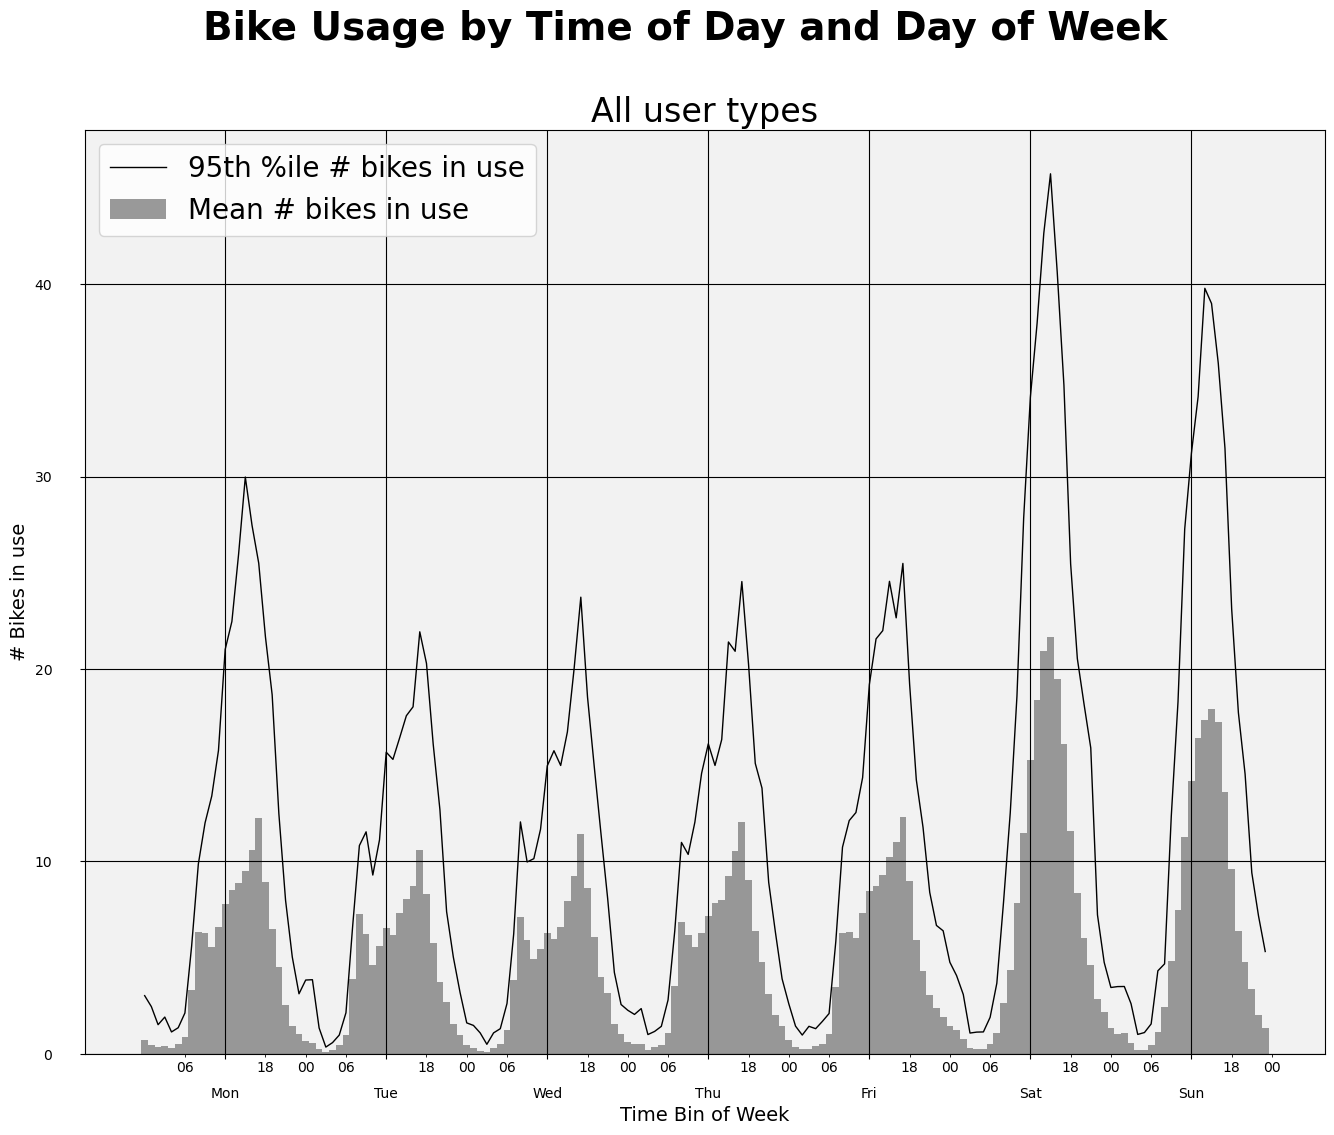

In [41]:
# Create a Figure and Axes object
#--------------------------------

fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)

# Create a list to use as the X-axis values
#-------------------------------------------

timestamps = pd.date_range('01/05/2015', periods=168, freq='60Min').tolist()

major_tick_locations = pd.date_range('01/05/2015 12:00:00', periods=7, freq='24H').tolist()
minor_tick_locations = pd.date_range('01/05/2015 06:00:00', periods=28, freq='6H').tolist()

# Specify the mean occupancy and percentile values
#-----------------------------------------------------------
mean_occ = occ_df['mean']
pctile_occ = occ_df['p95']

# Styling of bars, lines, plot area
#-----------------------------------

# Style the bars for mean occupancy
bar_color = 'grey'
bar_opacity = 0.8

# Style the line for the occupancy percentile
pctile_line_style = '-'
pctile_color = 'black'
pctile_line_width = 1

# Set the background color of the plot. Argument is a string float in
# (0,1) representing greyscale (0=black, 1=white)
ax1.patch.set_facecolor('0.95')

# Can also use color names or hex color codes
# ax2.patch.set_facecolor('yellow')
# ax2.patch.set_facecolor('#FFFFAD')


# Add data to the plot
#--------------------------

# Mean occupancy as bars - here's the GOTCHA involving the bar width
ax1.bar(timestamps, mean_occ, color=bar_color, alpha=bar_opacity, label='Mean # bikes in use', width=1/24)

# Some percentile as a line
ax1.plot(timestamps, pctile_occ, linestyle=pctile_line_style, linewidth=pctile_line_width, color=pctile_color, \
         label='95th %ile # bikes in use')


# Create formatter variables
dayofweek_formatter = DateFormatter('%a')
qtrday_formatter = DateFormatter('%H')

# Set the tick locations for the axes object

ax1.set_xticks(major_tick_locations)
ax1.set_xticks(minor_tick_locations, minor=True)

# Format the tick labels
ax1.xaxis.set_major_formatter(dayofweek_formatter)
ax1.xaxis.set_minor_formatter(qtrday_formatter)

# Slide the major tick labels underneath the default location by 20 points
ax1.tick_params(which='major', pad=20)

# Add other chart elements
#-------------------------

# Set plot and axis titles
fig1.suptitle('Bike Usage by Time of Day and Day of Week', fontsize=28, fontweight='bold')
ax1.set_title('All user types', fontsize=24)
ax1.set_xlabel('Time Bin of Week', fontsize=14)
ax1.set_ylabel('# Bikes in use', fontsize=14)

# Gridlines
ax1.grid(True, color='k')

# Legend
leg = ax1.legend(loc='best', frameon=True, fontsize=20)
leg.get_frame().set_facecolor('white')

# Plot size
fig1.set_size_inches(16,12)

## Weekdays only and weekends only
Now we'll create separate plots for weekdays and weekends and we'll stack the bars based on user type.

In [44]:
# Gather various series to use in the plots

shortterm_df = occ_user_type_df.loc['Short-Term Pass Holder']
member_df = occ_user_type_df.loc['Member']

# Remember that weekdays are number 0 to 6 in Python with 0=Monday

wkday_mean_shortterm_occ = shortterm_df.loc[0:4]['mean']
wkday_mean_member_occ = member_df.loc[0:4]['mean']
wkday_p95_total_occ = occ_df.loc[0:4]['p95']
wkday_p75_total_occ = occ_df.loc[0:4]['p75']

wkend_mean_shortterm_occ = shortterm_df.loc[5:6]['mean']
wkend_mean_member_occ = member_df.loc[5:6]['mean']
wkend_p95_total_occ = occ_df.loc[5:6]['p95']
wkend_p75_total_occ = occ_df.loc[5:6]['p75']

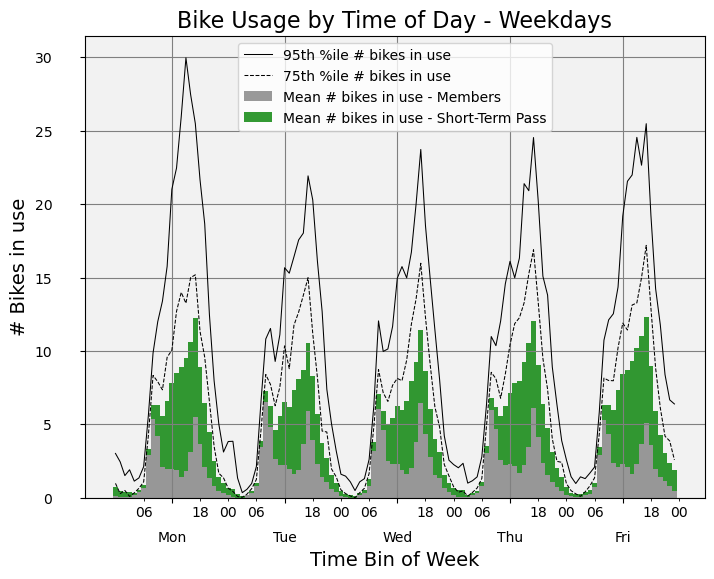

In [46]:
# Create a Figure and Axes object
#--------------------------------

fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1)

# Create a list to use as the X-axis values
#-------------------------------------------

timestamps = pd.date_range('01/05/2015', periods=120, freq='60Min').tolist()

major_tick_locations = pd.date_range('01/05/2015 12:00:00', periods=5, freq='24H').tolist()
minor_tick_locations = pd.date_range('01/05/2015 06:00:00', periods=20, freq='6H').tolist()


# Styling of bars, lines, plot area
#-----------------------------------

# Style the bars for mean occupancy
bar_color_member = 'grey'
bar_color_shortterm = 'green'
bar_opacity = 0.8

# Style the line for the occupancy percentile
pctile95_line_style = '-'
pctile75_line_style = '--'
pctile_color = 'black'
pctile_line_width = 0.75

# Set the background color of the plot. Argument is a string float in
# (0,1) representing greyscale (0=black, 1=white)
ax2.patch.set_facecolor('0.95')

# Can also use color names or hex color codes
# ax2.patch.set_facecolor('yellow')
# ax2.patch.set_facecolor('#FFFFAD')


# Add data to the plot
#--------------------------

label_member = 'Mean # bikes in use - Members'
label_shortterm = 'Mean # bikes in use - Short-Term Pass'

# Mean occupancy as bars
ax2.bar(timestamps, wkday_mean_member_occ, color=bar_color_member, alpha=bar_opacity, label=label_member, width=1/24)
ax2.bar(timestamps, wkday_mean_shortterm_occ, bottom=wkday_mean_member_occ, color=bar_color_shortterm, 
        alpha=bar_opacity, label=label_shortterm, width=1/24)

# Percentiles as lines
ax2.plot(timestamps, wkday_p95_total_occ, linestyle=pctile95_line_style, linewidth=pctile_line_width, color=pctile_color, \
         label='95th %ile # bikes in use')

ax2.plot(timestamps, wkday_p80_total_occ, linestyle=pctile75_line_style, linewidth=pctile_line_width, color=pctile_color, \
         label='75th %ile # bikes in use')


# Create formatter variables
dayofweek_formatter = DateFormatter('%a')
qtrday_formatter = DateFormatter('%H')

# Set the tick locations for the axes object
ax2.set_xticks(major_tick_locations)
ax2.set_xticks(minor_tick_locations, minor=True)

# Format the tick labels
ax2.xaxis.set_major_formatter(dayofweek_formatter)
ax2.xaxis.set_minor_formatter(qtrday_formatter)

# Slide the major tick labels underneath the default location by 20 points
ax2.tick_params(which='major', pad=20)

# Add other chart elements
#-------------------------

# Set plot and axis titles
ax2.set_title('Bike Usage by Time of Day - Weekdays', fontsize=16)
ax2.set_xlabel('Time Bin of Week', fontsize=14)
ax2.set_ylabel('# Bikes in use', fontsize=14)

# Gridlines
ax2.grid(True, color='grey')

# Legend
leg = ax2.legend(loc='best', frameon=True, fontsize=10)
leg.get_frame().set_facecolor('white')

# Plot size
fig2.set_size_inches(8,6)

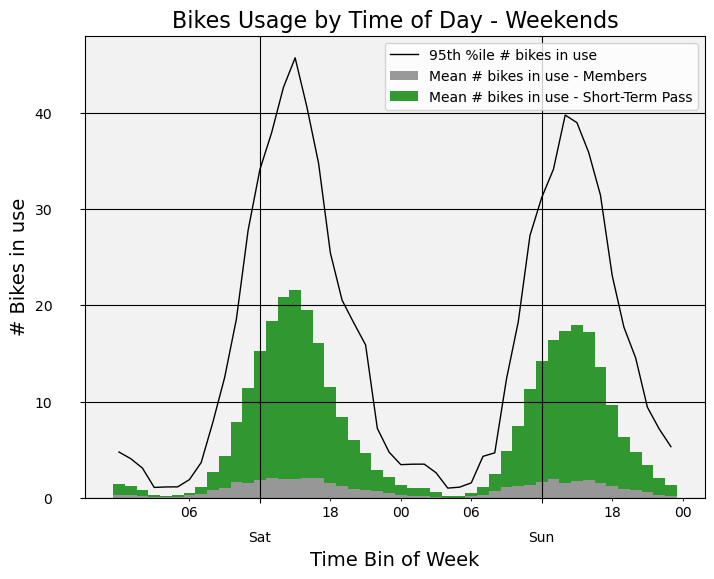

In [47]:
# Create a Figure and Axes object
#--------------------------------

fig3 = plt.figure()
ax3 = fig3.add_subplot(1,1,1)

# Create a list to use as the X-axis values
#-------------------------------------------

timestamps = pd.date_range('01/03/2015', periods=48, freq='60Min').tolist()

major_tick_locations = pd.date_range('01/03/2015 12:00:00', periods=2, freq='24H').tolist()
minor_tick_locations = pd.date_range('01/03/2015 06:00:00', periods=8, freq='6H').tolist()


# Styling of bars, lines, plot area
#-----------------------------------

# Style the bars for mean occupancy
bar_color_member = 'grey'
bar_color_shortterm = 'green'
bar_opacity = 0.8

# Style the line for the occupancy percentile
pctile_line_style = '-'
pctile_color = 'black'
pctile_line_width = 1

# Set the background color of the plot. Argument is a string float in
# (0,1) representing greyscale (0=black, 1=white)
ax3.patch.set_facecolor('0.95')

# Can also use color names or hex color codes
# ax2.patch.set_facecolor('yellow')
# ax2.patch.set_facecolor('#FFFFAD')


# Add data to the plot
#--------------------------

label_member = 'Mean # bikes in use - Members'
label_shortterm = 'Mean # bikes in use - Short-Term Pass'

# Mean occupancy as bars
ax3.bar(timestamps, wkend_mean_member_occ, color=bar_color_member, alpha=bar_opacity, label=label_member, width=1/24)
ax3.bar(timestamps, wkend_mean_shortterm_occ, bottom=wkend_mean_member_occ, color=bar_color_shortterm, 
        alpha=bar_opacity, label=label_shortterm, width=1/24)

# Some percentile aas a line
ax3.plot(timestamps, wkend_p95_total_occ, linestyle=pctile_line_style, linewidth=pctile_line_width, color=pctile_color, \
         label='95th %ile # bikes in use')


# Create formatter variables
dayofweek_formatter = DateFormatter('%a')
qtrday_formatter = DateFormatter('%H')

# Set the tick locations for the axes object

ax3.set_xticks(major_tick_locations)
ax3.set_xticks(minor_tick_locations, minor=True)

# Format the tick labels
ax3.xaxis.set_major_formatter(dayofweek_formatter)
ax3.xaxis.set_minor_formatter(qtrday_formatter)

# Slide the major tick labels underneath the default location by 20 points
ax3.tick_params(which='major', pad=20)

# Add other chart elements
#-------------------------

# Set plot and axis titles

ax3.set_title('Bikes Usage by Time of Day - Weekends', fontsize=16)
ax3.set_xlabel('Time Bin of Week', fontsize=14)
ax3.set_ylabel('# Bikes in use', fontsize=14)

# Gridlines
ax3.grid(True, color='k')

# Legend
leg = ax3.legend(loc='upper right', frameon=True, fontsize=10)
leg.get_frame().set_facecolor('white')

# Plot size
fig3.set_size_inches(8,6)

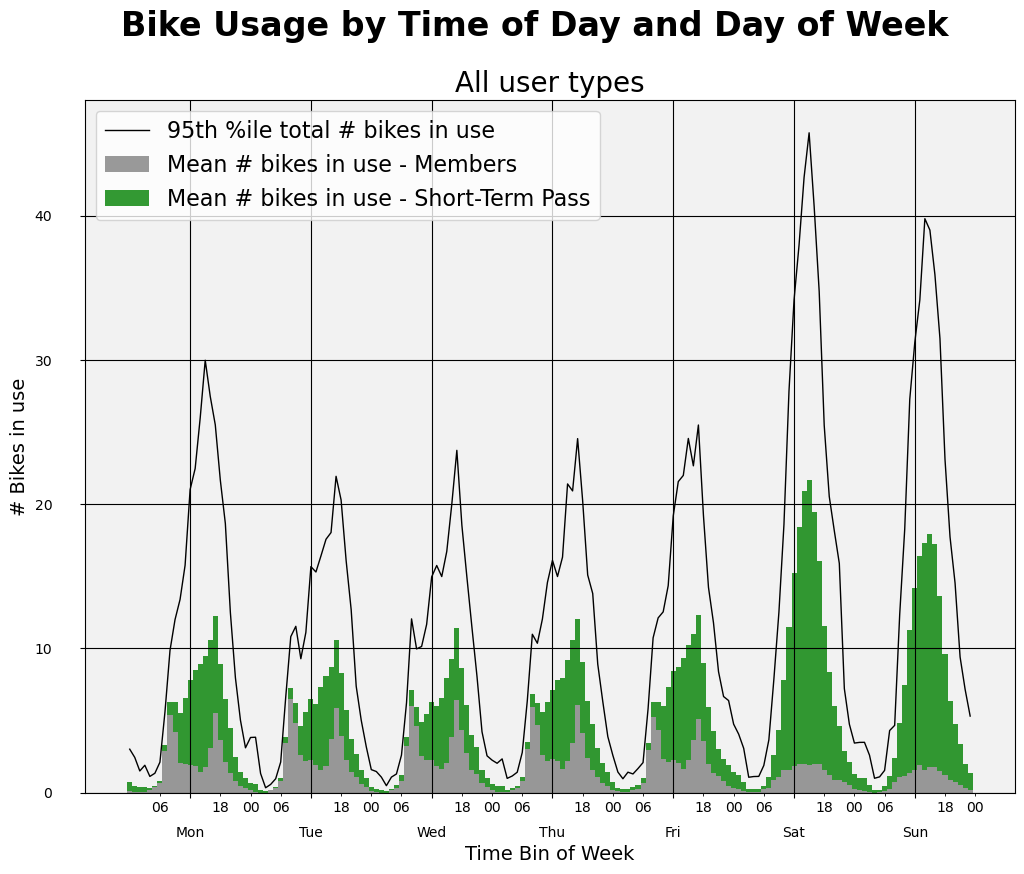

In [52]:
# Create a Figure and Axes object
#--------------------------------

fig4 = plt.figure()
ax4 = fig4.add_subplot(1,1,1)

# Create a list to use as the X-axis values
#-------------------------------------------

timestamps = pd.date_range('01/05/2015', periods=168, freq='60Min').tolist()

major_tick_locations = pd.date_range('01/05/2015 12:00:00', periods=7, freq='24H').tolist()
minor_tick_locations = pd.date_range('01/05/2015 06:00:00', periods=28, freq='6H').tolist()

# Specify the mean occupancy and percentile values
#-----------------------------------------------------------
mean_shortterm_occ = occ_user_type_df.loc['Short-Term Pass Holder']['mean']
mean_member_occ = occ_user_type_df.loc['Member']['mean']
p95_total_occ = occ_df['p95']

# Styling of bars, lines, plot area
#-----------------------------------

# Style the bars for mean occupancy
bar_color_member = 'grey'
bar_color_shortterm = 'green'
bar_opacity = 0.8

# Style the line for the occupancy percentile
pctile_line_style = '-'
pctile_color = 'black'
pctile_line_width = 1

# Set the background color of the plot. Argument is a string float in
# (0,1) representing greyscale (0=black, 1=white)
ax4.patch.set_facecolor('0.95')

# Can also use color names or hex color codes
# ax2.patch.set_facecolor('yellow')
# ax2.patch.set_facecolor('#FFFFAD')


# Add data to the plot
#--------------------------

label_member = 'Mean # bikes in use - Members'
label_shortterm = 'Mean # bikes in use - Short-Term Pass'

# Mean occupancy as bars
ax4.bar(timestamps, mean_member_occ, color=bar_color_member, alpha=bar_opacity, label=label_member, width=1/24)
ax4.bar(timestamps, mean_shortterm_occ, bottom=mean_member_occ, color=bar_color_shortterm, 
        alpha=bar_opacity, label=label_shortterm, width=1/24)


# Some percentile aas a line
ax4.plot(timestamps, p95_total_occ, linestyle=pctile_line_style, linewidth=pctile_line_width, color=pctile_color, \
         label='95th %ile total # bikes in use')


# Create formatter variables
dayofweek_formatter = DateFormatter('%a')
qtrday_formatter = DateFormatter('%H')

# Set the tick locations for the axes object

ax4.set_xticks(major_tick_locations)
ax4.set_xticks(minor_tick_locations, minor=True)

# Format the tick labels
ax4.xaxis.set_major_formatter(dayofweek_formatter)
ax4.xaxis.set_minor_formatter(qtrday_formatter)

# Slide the major tick labels underneath the default location by 20 points
ax4.tick_params(which='major', pad=20)

# Add other chart elements
#-------------------------

# Set plot and axis titles
fig4.suptitle('Bike Usage by Time of Day and Day of Week', fontsize=24, fontweight='bold')
ax4.set_title('All user types', fontsize=20)
ax4.set_xlabel('Time Bin of Week', fontsize=14)
ax4.set_ylabel('# Bikes in use', fontsize=14)

# Gridlines
ax4.grid(True, color='k')

# Legend
leg = ax4.legend(loc='best', frameon=True, fontsize=16)
leg.get_frame().set_facecolor('white')

# Plot size
fig4.set_size_inches(12,9)

Lots more we can do, but this should illustrate the basic idea.